# Preload libraries and functions
First of all, let's import libraries that will be used in this example

In [41]:
# clear all variants
# %reset -f   

# Autoreload the customize modules.
%reload_ext autoreload
# Or load_ext autoreload for the first run
# %aimport
%autoreload 2

import pandas as pd
import numpy as np
from sklearn import preprocessing as prep
import matplotlib.pyplot as plt
import time

# import tensorflow as tf
# from tensorflow import keras

import HackModules.HackClasses as hc
import HackModules.HackFunctions as hf
from HackModules.progressMonitor import progressBar
from HackModules.progressMonitor import timer

#matplot inline
# np.set_printoptions(precision=8)

# help(hc) # To test the docstrings ((TBDBS To be deleted before submission))

# Alternative customize module import method
# import sys, os
# sys.path.append(os.getcwd()+'/HackModules/') # add /HackModules to the path
# import HackClasses as hc


Define some seldom used functions and class

# Data Import and Initialization

In [7]:
df = pd.read_excel('obs_data_w.xlsx', sheet_name=0) #sheet_name='Sheet1')
print(df)

         V    T  uncertainty             J
0     0.00  100     0.001000  0.000000e+00
1     0.05  100     0.001000  6.417136e-90
2     0.10  100     0.001000  1.081096e-88
3     0.15  100     0.001000  1.719633e-87
4     0.20  100     0.001000  2.725747e-86
5     0.25  100     0.001000  4.319561e-85
6     0.30  100     0.001000  6.845225e-84
7     0.35  100     0.001000  1.084764e-82
8     0.40  100     0.001000  1.719028e-81
9     0.45  100     0.001000  2.724148e-80
10    0.50  100     0.001000  4.316963e-79
11    0.55  100     0.001000  6.841100e-78
12    0.60  100     0.001000  1.084111e-76
13    0.65  100     0.001000  1.717992e-75
14    0.70  100     0.001000  2.722506e-74
15    0.75  100     0.001000  4.314361e-73
16    0.80  100     0.001000  6.836977e-72
17    0.85  100     0.001000  1.083457e-70
18    0.90  100     0.001000  1.716957e-69
19    0.95  100     0.001000  2.720865e-68
20    1.00  100     0.001000  4.311761e-67
21    1.05  100     0.001000  6.832857e-66
22    1.10 

## Train, cross validation and test data

### Random Method 1: Sample function of df

In [8]:
tcv=df.sample(frac=0.8) # random_state=200
test=df.drop(tcv.index)
test=test.sample(frac=1) # shuffle the rows

print(test.shape)

(1579, 4)


### Random Method 2: random array

In [ ]:
# idx=np.arange(0,len(df))
# np.random.shuffle(idx)
# temp_split=math.floor(0.8*len(df))
# #idx[0:20]
# train=df.iloc[idx[0:temp_split],:]
# test=df.iloc[idx[temp_split:],:] # Output all the elements after temp_split
# print(train.shape)
# print(test.shape)

## Split test data into data and results, add polynominal features and normalize them.

In [39]:
test_data=test.loc[:,['V','T']]
test_unc=test.uncertainty.values
test_J=test.J.values

degree = 2
test_data=hc.data(test_data,degree=degree,method='std')

print(f'The polynominal degree is {degree}.\n')
print('Polynominal test data = \n', test_data.poly, '\n')
print('Normalized test_data = \n', test_data.norm, '\n')

The polynominal degree is 2.

Polynominal test data = 
 [[1.65000e+00 1.01000e+02 2.72250e+00 1.66650e+02 1.02010e+04]
 [2.85000e+00 1.39000e+02 8.12250e+00 3.96150e+02 1.93210e+04]
 [3.00000e+00 1.33000e+02 9.00000e+00 3.99000e+02 1.76890e+04]
 ...
 [3.35000e+00 1.22000e+02 1.12225e+01 4.08700e+02 1.48840e+04]
 [2.00000e-01 1.24000e+02 4.00000e-02 2.48000e+01 1.53760e+04]
 [1.35000e+00 6.20000e+02 1.82250e+00 8.37000e+02 3.84400e+05]] 

Normalized test_data = 
 [[ 1.         -0.0681642  -0.65881345 -0.34902051 -0.6287151  -0.41891512]
 [ 1.          1.08348556 -0.35441244  1.07323105  0.61677167 -0.32085519]
 [ 1.          1.22744178 -0.40247575  1.30434693  0.6322385  -0.33840275]
 ...
 [ 1.          1.56333962 -0.49059184  1.88970881  0.68487998 -0.36856263]
 [ 1.         -1.45974098 -0.47457073 -1.05553715 -1.39852903 -0.36327256]
 [ 1.         -0.35607664  3.49866359 -0.58606244  3.00924591  3.60454212]] 



# Model Training

## Method 1: Normal Equation

### Training with regulation

Progress: |██████████████████████████████████████████████████| 100.00% Complete     Run: 00:00:26; Left: 00:00:00 (Total: 00:00:26)
The time cost is 26.935031175613403s
The mean value of beta with various regulation coefficients anddifferent training samples are:
[6.81292069e+00 1.77827941e-03]
The value of BETA should be  3.0204805898002562


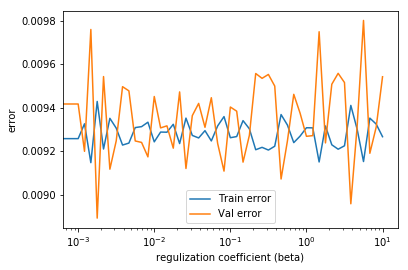

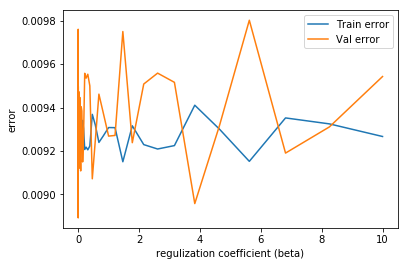

In [51]:
def train_model_smpl(i, j, beta):
#     print(f'Loop {i}-{index}-{j} is running...\n')
    
    # Split into train set and cv set
    train=tcv.sample(frac=0.75) #, random_state = int((157*j+71*i)/3))
    cv=tcv.drop(train.index)

    train_data=hc.data(train.loc[:,['V','T']], degree=2, method ='std')
    train_unc=train.uncertainty.values
    train_J=train.J.values

    cv_data=hc.data(cv.loc[:,['V','T']], degree=2, method ='std')
    cv_unc=cv.uncertainty.values
    cv_J=cv.J.values

    theta_reg=hf.normalRegEq(train_data.norm, train_J, beta)
    error_train_reg_smpl=hf.computeCost(train_data.norm, train_J, theta_reg)
    error_cv_reg_smpl=hf.computeCost(cv_data.norm, cv_J, theta_reg)
    return error_train_reg_smpl, error_cv_reg_smpl
    
#   print(f'Loop {i}-{index}-{j} ended.\n')


def train_model_loop(beta_num, epoch):
    # theta_reg_multismpl=np.zeros((epoch, featureSize))
    error_train_reg_multismpl=np.zeros(epoch)
    error_cv_reg_multismpl=np.zeros(epoch)
    beta_array=np.zeros(beta_num)
    # Initial call to print 0% progress
    total=beta_num*len(beta_range)
    pbar=progressBar(total, prefix = 'Progress:', suffix = 'Complete', decimals = 2, length = 50)
    tm=timer(total)
    
    for i in range(0,beta_num):
        for index, beta in enumerate(beta_range):
            for j in range(0,epoch,1):
                error_train_reg_multismpl[j], error_cv_reg_multismpl[j]=train_model_smpl(i,j,beta)
            
            # show the progess and timer
            iteration=i*len(beta_range)+(index+1)
            s1=pbar.update(iteration, ToPrint=False)
            s2=tm.update(iteration,ToPrint=False)
            print('\r'+s1+" "*5+s2,end='\r')
            
            error_train_reg[index] = error_train_reg_multismpl.sum(0)/epoch
            error_cv_reg[index] = error_cv_reg_multismpl.sum(0)/epoch
            iteration=i*len(beta_range)+(index+1)
            s1=pbar.update(iteration, ToPrint=False)
            s2=tm.update(iteration,ToPrint=False)
            print('\r'+s1+" "*5+s2,end='\r')
            
        idx=error_cv_reg.argmin()
        beta_array[i] = beta_range[idx]
        
    return beta_array


featureSize=test_data.norm.shape[1]
beta_range=np.geomspace(0.001,10, num = 50-1, endpoint = True, dtype=np.float64)
beta_range=np.insert(beta_range,0,0) # insert a zero element in the first index
error_train_reg=np.zeros(beta_range.size)
error_cv_reg=np.zeros(beta_range.size)

# Calculate the beta array
t_start=time.time()
beta_array=train_model_loop(2, 50)
t_end=time.time()
print(f'\nThe time cost is {t_end-t_start}s',end='\n')

print(f'The mean value of beta with various regulation coefficients and'+ 
      f'different training samples are:\n{beta_array}')

print('The value of BETA should be ', beta_best.mean())
# print('The test error with best THETA and BETA is ', error_test_reg)

# log-scale plot error vs. beta
plt.figure()
plt.semilogx(beta_range, error_train_reg, label = 'Train error')
plt.semilogx(beta_range, error_cv_reg, label = 'Val error')
plt.xlabel('regulization coefficient (beta)')
plt.ylabel('error')
plt.legend()

# plot error vs. beta
plt.figure()
plt.plot(beta_range, error_train_reg, label = 'Train error')
plt.plot(beta_range, error_cv_reg, label = 'Val error')
plt.xlabel('regulization coefficient (beta)')
plt.ylabel('error')
plt.legend()

# Prediction

In [50]:
beta_array.mean()

1.5102402949001281

In [ ]:
t=data(test_data)

In [ ]:
print(t.array)

In [ ]:
t.polyFeature(2)
t.array.shape

In [ ]:
type(theta_reg)